# RUBBERY MODULUS

In [15]:
# import required packages

import traceback
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    mean_absolute_error,
)
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.regularizers import l2
from keras.layers import Dense, Activation
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

### Data processing

In [16]:
# read data
filePath = r"C:\Users\Ama\OneDrive - Southern University System\02-MachineLearning\Dataset_for_practise\SMP-Er.csv"
df = pd.read_csv(filePath)
df

,Author,No,Names,Smiles,Molar ratio,Rubbery temperature,Rubbery modulus,Unnamed: 7
0,Castro2010,1,DEGDMA:tBA,{ C=C(C)C(=O)OCCOCCOCCOCCOCCOCCOCCOCCOC(=O)C(=...,0.025:0.975,84.80,1.50,NaN
1,NaN,2,DEGDMA:tBA,{ C=C(C)C(=O)OCCOCCOCCOCCOCCOCCOCCOCCOC(=O)C(=...,0.055 : 0.945,76.35,5.62,NaN
2,NaN,3,DEGDMA:tBA,{ C=C(C)C(=O)OCCOCCOCCOCCOCCOCCOCCOCCOC(=O)C(=...,0.134:0.866,72.09,11.51,NaN
3,NaN,4,PEGDMA:tBA,{ C=C(C)C(=O)OCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCC...,0.016:0.984,84.80,2.42,NaN
4,NaN,5,PEGDMA:tBA,{ C=C(C)C(=O)OCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCC...,0.035:0.965,76.35,5.55,NaN
...,...,...,...,...,...,...,...,...
241,"Yan et al., 2020",Epon862+MDS,1,"{ c2cc(OCC1CO1)ccc2Cc4ccc(OCC3CO3)cc4, Nc2ccc(...",0.5874 : 0.4126,170.00,14.54,13.0
242,NaN,Epon862 +Lupal FG+MDS,2,"{ c2cc(OCC1CO1)ccc2Cc4ccc(OCC3CO3)cc4,NCCNCCN(...",0.6445 : 0.0393 : 0.3162,160.00,21.25,NaN
243,NaN,Epon862 +Lupal FG+MDS,3,"{ c2cc(OCC1CO1)ccc2Cc4ccc(OCC3CO3)cc4,NCCNCCN(...",0.6886 : 0.0695 : 0.2418,155.00,21.85,NaN
244,NaN,Epon862 +Lupal FG+MDS,4,"{ c2cc(OCC1CO1)ccc2Cc4ccc(OCC3CO3)cc4,NCCNCCN(...",0.7402 : 0.1044 : 0.1554,145.00,28.35,NaN


In [17]:
#
smiles = df["Smiles"]
smiles = [list(smile.strip("{} ").split(",")) for smile in smiles]

molar_ratio = df["Molar ratio"]
m_r = []
for entry in molar_ratio:
    ratio_list = [float(x) for x in entry.split(":")]
    m_r.append(ratio_list)

In [18]:
"""'
functions for fingerprinting and multiplication of 
fingerprinted monomers by their respective molar ratios
"""


# function for fingerprinting
def fingerprint_monomer(monomer):
    mol = Chem.MolFromSmiles(monomer)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 10, nBits=128)
    return fp


# function for storing fingerprints monomers as a representation of the polymers
def fingerprint_polymer(polymer):
    polymer_fp = []
    for monomer in polymer:
        monomer_fp = fingerprint_monomer(monomer)
        polymer_fp.append(monomer_fp)
    return polymer_fp


# function for multiplication by their respective molar ratios
def multiply_fingerprint(fp, m_r_value):
    return np.multiply(fp, m_r_value)


fingerprinted_polymer_data = []
for polymer, polymer_m_r in zip(smiles, m_r):
    fingerprinted_polymer = fingerprint_polymer(polymer)
    multiplied_polymer = [
        multiply_fingerprint(fp, m_r_value)
        for fp, m_r_value in zip(fingerprinted_polymer, polymer_m_r)
    ]
    fingerprinted_polymer_data.append(multiplied_polymer)


# flatten the array created and storing them in a list
flattened_arr = [np.concatenate(arr) for arr in fingerprinted_polymer_data]

# find the maximum length of the flattened arrays
max_length = max(len(arr) for arr in flattened_arr)

# pad the arrays with zeros to make them the same length
padded_arrays = [
    np.pad(arr, (0, max_length - len(arr)), mode="constant") for arr in flattened_arr
]

new_array = np.stack(padded_arrays)

In [19]:
X = new_array
y = df["Rubbery modulus"]  # specify y

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

# # Initialize the scaler
# scaler = MinMaxScaler()

# # Fit the scaler on the training data and transform it
# X_train_normalized = scaler.fit_transform(X_train)

# # Apply the same transformation to the test data
# X_test_normalized = scaler.transform(X_test)

x_plot = np.linspace(0, 12)
y_plot = x_plot

### ANN Model

In [21]:
mycallback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mape",
    min_delta=0.0001,
    patience=100,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

Epoch 1/1000
7/7 [==============================] - 2s 46ms/step - loss: 23.6037 - mape: 100.0773 - val_loss: 22.7438 - val_mape: 98.7622
Epoch 2/1000
7/7 [==============================] - 0s 9ms/step - loss: 23.3340 - mape: 96.5921 - val_loss: 22.4054 - val_mape: 94.9298
Epoch 3/1000
7/7 [==============================] - 0s 10ms/step - loss: 22.8822 - mape: 91.3841 - val_loss: 21.7337 - val_mape: 87.7944
Epoch 4/1000
7/7 [==============================] - 0s 10ms/step - loss: 22.0999 - mape: 85.1966 - val_loss: 20.6387 - val_mape: 76.1631
Epoch 5/1000
7/7 [==============================] - 0s 9ms/step - loss: 20.9095 - mape: 78.2968 - val_loss: 19.1253 - val_mape: 59.9298
Epoch 6/1000
7/7 [==============================] - 0s 13ms/step - loss: 19.4291 - mape: 74.1623 - val_loss: 17.8603 - val_mape: 56.0230
Epoch 7/1000
7/7 [==============================] - 0s 11ms/step - loss: 17.7747 - mape: 75.0789 - val_loss: 16.8871 - val_mape: 64.7591
Epoch 8/1000
7/7 [========================

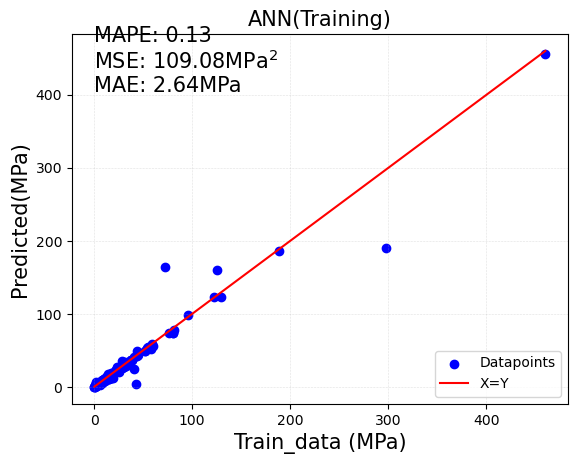

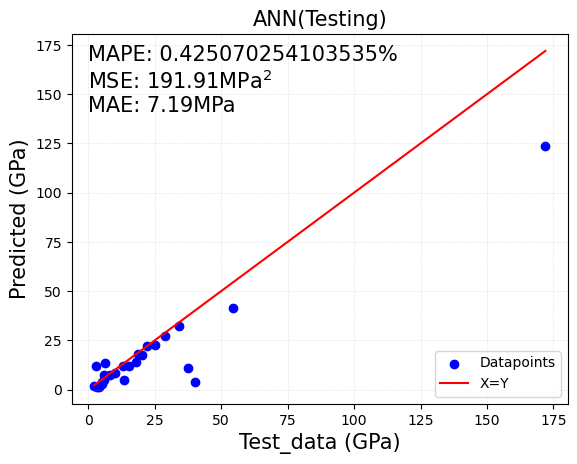

In [23]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            32,
            activation="relu",
            kernel_regularizer=l2(0.001),
            input_shape=(X_train.shape[1],),
        ),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(4, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)


# Compile the model
model.compile(loss="mae", optimizer=optimizer, metrics=["mape"])

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[mycallback],
)
# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)


# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color="b", label="Datapoints")
plt.plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", label="X=Y"
)
plt.xlabel("Train_data (MPa)", fontsize=15)
plt.ylabel("Predicted(MPa)", fontsize=15)
plt.text(
    0,
    495,
    f"MAPE: {MAPE_train:.2f}\nMSE: {MSE_train:.2f}MPa$^2$\nMAE: {MAE_train:.2f}MPa",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Training)", fontsize=15)
# plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color="b", label="Datapoints")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", label="X=Y")
plt.xlabel("Test_data (GPa)", fontsize=15)
plt.ylabel("Predicted (GPa)", fontsize=15)
plt.text(
    0,
    175,
    f"MAPE: {MAPE_test:.2f}\nMSE: {MSE_test:.2f}MPa$^2$\nMAE: {MAE_test:.2f}MPa",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Testing)", fontsize=15)
# plt.legend()
plt.show()